# Introduction and Overview

* [OOI on Quality Control](https://ooi-website.whoi.edu/quality-control/)
* [OOI on Data](https://oceanobservatories.org/tag/data/)
* [OOI Data Explorer example](https://dataexplorer.oceanobservatories.org/#ooi/array/RS/platform_type/profiling-assets/annotations?instrument_type_id=FLUOR)
* [Notebook reference on OOI QC flags (Peter Cable)](https://github.com/petercable/shared_notebooks/blob/master/qc_flags/qc_flags.ipynb)
* [Notebook on OOI data exploration using Python (Chris Wingard)](https://github.com/oceanobservatories/ooi-data-explorations/tree/master/python)
* [Notebook on Human In The Loop QC (Chris Wingard)](https://github.com/oceanobservatories/ooi-data-explorations/blob/master/python/examples/notebooks/dosta/ooiea_dosta_annotations_hitl_qc.ipynb)


Temporary references


* [chapter flowcharts](https://docs.google.com/presentation/d/1WuEsncfrxf_43osxAL-2g6dew1qh0wcXf2Lg5vNwCas/edit?pli=1#slide=id.g142d4c244fd_0_124)
* [pseudo-code document](https://docs.google.com/document/d/1gQhFzkthh-S116F_p32hoF_uw22MB3mKF3DKyUtmIxw/edit#)
* [flort flowchart](https://docs.google.com/drawings/d/1CYWFAGMNZQa8W3xFslrI9uXyHW78q24KhBOhiTMUz98/edit)


## Data summary


This notebook follows the QC narrative for biooptics (fluorescence, specifically) to produce draft figures
for the OOI QC Data Guide. A fluorometer triplet ('flort') consists of three sensors that generate
the data discussed below. The fluorometer triplet
is deployed on the Regional Cabled Array "Oregon Slope Base" shallow profiler.
The profiler runs through nine ascent/descent cycles each day from a depth of 200 meters 
to a depth of 10 meters.
The time frames discussed here are June 14, 2019 and the month of March 2021 (later
constrained to a single day, March 10, 2021). 



## Obtaining full resolution data


### Use the **`oceanobservatories.org`** Data Explorer


Circa 2022 the data access / download procedure runs thus: 
- [OOI Data Explorer, Oregon coast, RCA, Oregon Slope Base, Profiler](https://dataexplorer.oceanobservatories.org/#ooi/array/RS/platform_type/profiling-assets/data?instrument_type_id=FLUOR)
- [Choose the Downloads tab](https://dataexplorer.oceanobservatories.org/#ooi/array/RS/platform_type/profiling-assets/downloads?instrument_type_id=FLUOR)
- [Under Oregon Slope Base Shallow Profiler CDOM select Full resolution dataset](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/2000/sensor/downloads)


### Specific to June 14, 2019


- For the dataset used below that ends June 14, 2019: [Use the green Downloads button for Deployment - 0006 and choose Dataset under THREDDS catalog](http://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html)
- A new browser tab opens listing many files with similar names. Scroll down to find and select the file [deployment0006_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20190410T120000.534756-20190614T051241.816166.nc](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html?dataset=ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0006_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20190410T120000.534756-20190614T051241.816166.nc)
- [Click the HTTPServer link to initiate the download](/thredds/fileServer/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0006_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20190410T120000.534756-20190614T051241.816166.nc)


### Specific to March 10, 2021


- For the dataset used below that spans the month of May 2021: [Use the green Downloads button for Deployment - 0008 and choose Dataset under THREDDS catalog](http://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html). Note: This is the same link as above, in fact: Both go to a listing of many files corresponding to the sequence of deployments. In what follows the idea is to select a later (deployment 0008) file for download, specifically the one that spans March 2021.
- A new browser tab opens listing many files with similar names. Scroll down to find and select the file [deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/catalog.html?dataset=ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc)
- [Click the HTTPServer link to initiate the download](/thredds/fileServer/ooigoldcopy/public/RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record/deployment0008_RS01SBPS-SF01A-3A-FLORTD101-streamed-flort_d_data_record_20210123T120000.228181-20210414T115959.167518.nc)




## ***TO DO: Obtain tabular/CSV Annotation files for HITL***



## Remark: Data size limitations


This repository is subject to size constraints. The data files described above exceed 1GB in total
and so are placed in a source folder external to this repository. The relative paths to the 2019
and 2021 datasets are respectively
`../data/rca/fluor/osb/2021/flort_fullres.nc` 
and `../data/rca/fluor/osb/2019/flort_fullres.nc`.


## Remark: Streamlining this code


This notebook uses 'helper' Python code located in `DataQualityGuideModule.py`.
The helper code is imported in the first Python cell below.

In [3]:
# Set up this notebook to use code from an accompanying Python module file
from DataQualityGuideModule import *
print('\nJupyter running Python {}'.format(sys.version_info[0]))


Jupyter running Python 3


# Dataset Preparation


The data are managed through Python XArray structures called Datasets. This narrative begins with
data from 2021. The 2019 data are treated in similar fashion in section 6, which concerns comparison
with discrete (ship cast) data. 


The data in the `flort_fullres.nc` files are assigned to XArray Dataset variables. Below
this is variable `D`. `D` is then slightly modified and the contents are examined in the
following cell. Note that this will not run unless the cell above is run first. 

In [4]:
# open the dataset (chlor-a, fdom/cdom and backscatter) as variable 'D'
D = xr.open_dataset('../data/rca/fluor/osb/2021/flort_fullres.nc')

# substitute time for 'observation number' as the primary dimension
D = D.swap_dims({'obs':'time'})

# diagnostic: how many data values present
print('Number of data values: after file is opened, before time range narrowed to March 2021: ', len(D.time))

# narrow the time range to March 2021 (31 days, 86400 seconds per day: 2678400 samples
D = D.sel(time=slice(dt64('2021-03-01'), dt64('2021-04-01')))

# diagnostic: Number of data values after time window applied
print("Number of data values: March 2021 only, compare to 'one per second' total of 2678400: ", len(D.time))

# drop NaN values
D = D.dropna('time')

# diagnostic: Number of data values: after dropping NaNs
print('D number of data values after dropping NaN values is the same: ', len(D.time))

# rename the three sensor data streams; this makes them easier to read
D = D.rename( {'fluorometric_cdom':          'fdom',
               'fluorometric_chlorophyll_a': 'chlora',
               'optical_backscatter':        'backscatter'})

# The line of code below, just the letter 'D', is a reference to the full dataset. This simply produces a 
#   printout of its structure in terms of four components: Dimensions, Coordinates, Data Variables and Attributes.
#       Dimensions:      1: time
#       Coordinates:     5: time and depth (of the profiler) are the key coordinates 
#       Data Variables: 39: 3 fluorometer sensors (chlor-a, backscatter, fdom/cdom) plus 36 additional parameters:
#                             Eight qc (quality control) flags:
#                                 fluorometric_chlorophyll_a_qc_executed, ...qc_results
#                                 fluorometric_cdom_qc_executed, ...qc_results
#                                 optical_backscatter_qc_executed, ...qc_results
#                                 total_volume_scattering_coefficient_qc_executed, ...qc_results
#                             Temperature and Salinity: seawater_temperature, practical_salinity
#                             For calculating particulate scattering: seawater_scattering_coefficient
#                                 
#       Attributes:     68: This is ancillary metadata such as fluormeter model and manufacturer

D

Number of data values: after file is opened, before time range narrowed to March 2021:  5830998
Number of data values: March 2021 only, compare to 'one per second' total of 2678400:  2231042
D number of data values after dropping NaN values is the same:  2231042


<xarray.Dataset>
Dimensions:                                          (time: 2231042)
Coordinates:
    obs                                              (time) int32 2627967 ......
    lon                                              (time) float64 ...
    lat                                              (time) float64 ...
    depth                                            (time) float64 ...
  * time                                             (time) datetime64[ns] 20...
Data variables: (12/39)
    practical_salinity                               (time) float64 33.87 ......
    fluorometric_chlorophyll_a_qc_results            (time) uint8 12 12 ... 12
    fdom                                             (time) float64 1.3 ... 1...
    signal_3_offset                                  (time) float32 0.0 ... 0.0
    fluorometric_cdom_qc_executed                    (time) uint8 29 29 ... 29
    measurement_wavelength_cdom                      (time) float32 460.0 ......
    ...                                               ...
    total_volume_scattering_coefficient              (time) float64 9.269e-05...
    signal_2_offset                                  (time) float32 0.0 ... 0.0
    chlora                                           (time) float64 -0.0107 ....
    raw_internal_temp                                (time) float32 549.0 ......
    backscatter                                      (time) float64 0.0006074...
    fluorometric_cdom_qc_results                     (time) uint8 29 29 ... 29
Attributes: (12/68)
    node:                               SF01A
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -125.3896636
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

# Figure 1: Examine data

The starting point is to inspect data from the fluorometer triplet, in sequence chlorophyll-a, backscatter and fdom/cdom. 
The data time range has been narrowed to March 2021. A second narrowing is done to just March 10 2021.
Some aberrant spikes are apparent in the FDOM, addressed subsequently.

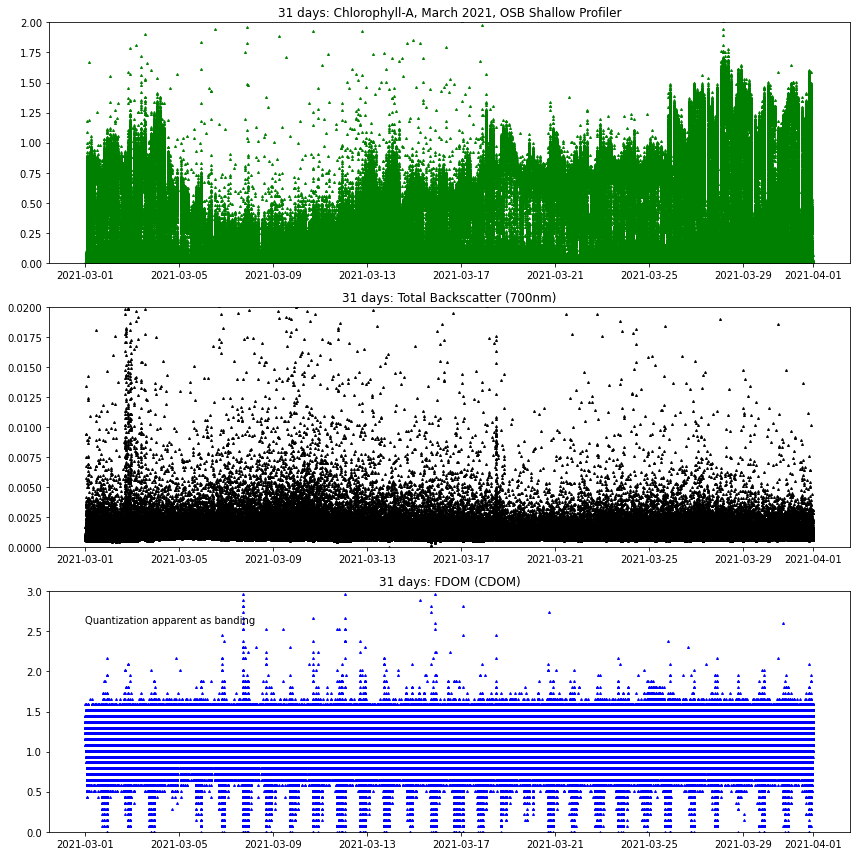

In [6]:
fig,axs=plt.subplots(3, figsize=(12,12), tight_layout=True)

axs[0].plot(D.time, D.chlora,       ms=2., marker='^', linestyle='None', color='g')
axs[1].plot(D.time, D.backscatter,  ms=2., marker='^', linestyle='None', color='k')
axs[2].plot(D.time, D.fdom,         ms=2., marker='^', linestyle='None', color='b')


axs[0].set(ylim=(0.0, 2.0), title='31 days: Chlorophyll-A, March 2021, OSB Shallow Profiler')
axs[1].set(ylim=(0.0, .02), title='31 days: Total Backscatter (700nm)')
axs[2].set(ylim=(0.0, 3.0), title='31 days: FDOM (CDOM)')

axs[2].text(dt64('2021-03-01'), 2.6, 'Quantization apparent as banding')

fig.show()

Text(2021-03-10, 2.6, 'Quantization apparent as banding')

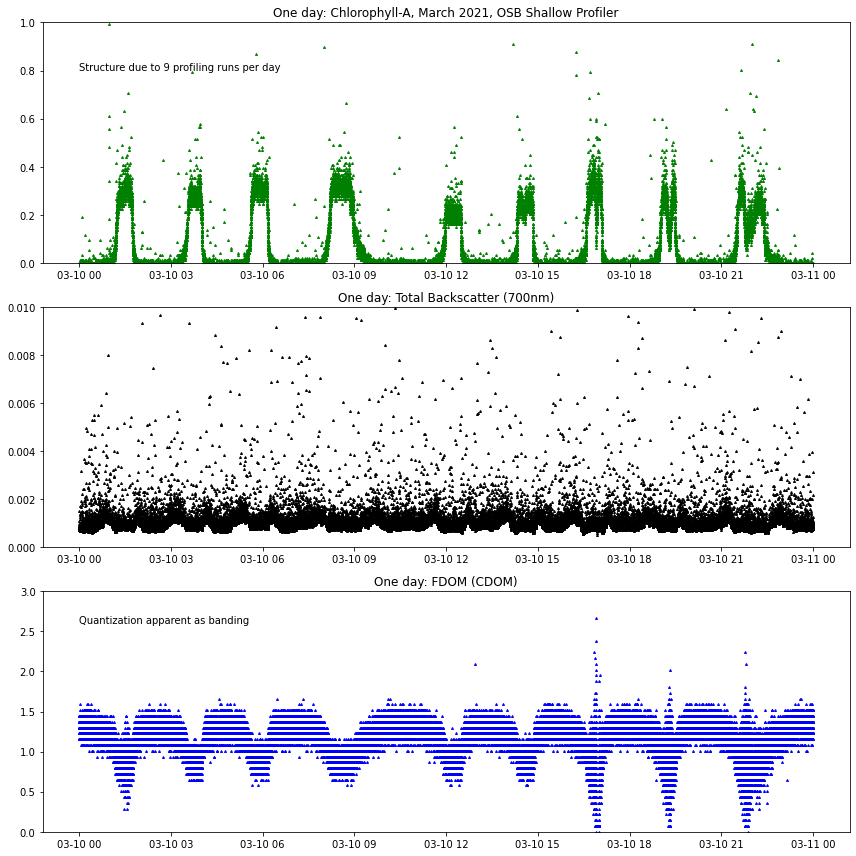

In [7]:
D1 = D.sel(time=slice(dt64('2021-03-10'), dt64('2021-03-11')))   

fig,axs=plt.subplots(3, figsize=(12,12), tight_layout=True)

axs[0].plot(D1.time, D1.chlora,       ms=2., marker='^', linestyle='None', color='g')
axs[1].plot(D1.time, D1.backscatter,  ms=2., marker='^', linestyle='None', color='k')
axs[2].plot(D1.time, D1.fdom,         ms=2., marker='^', linestyle='None', color='b')


axs[0].set(ylim=(0.0, 1.0), title='One day: Chlorophyll-A, March 2021, OSB Shallow Profiler')
axs[1].set(ylim=(0.0, .01), title='One day: Total Backscatter (700nm)')
axs[2].set(ylim=(0.0, 3.0), title='One day: FDOM (CDOM)')

axs[0].text(dt64('2021-03-10'), 0.8, 'Structure due to 9 profiling runs per day')
axs[2].text(dt64('2021-03-10'), 2.6, 'Quantization apparent as banding')


## Remark: QC flags

OOI provides a [web guide to QC flags](https://oceanobservatories.org/knowledgebase/interpreting-qc-variables-and-results/)
to help with their interpretation. Below we examine the first qc flag value for `fluorometric_cdom_qc_executed`
This integer value (29) is interpreted as a series of binary flags (right to left) that tell which tests have been 
applied to the stream data.


In [8]:
# The very first 'cdom_qc_executed' flag in the dataset time series, in binary
bin(int(D.fluorometric_cdom_qc_executed[0]))

'0b11101'

Reading bits right to left: This indicates that tests 1, 3, 4 and 5 were completed. 
From the above web page these are respectively

```
1. global_range_test
2. dataqc_localrangetest: Not completed
3. dataqc_spiketest
4. dataqc_polytrendtest
5. dataqc_stuckvaluetest
6. dataqc_gradienttest: Not completed
```


As we will see, there are two extraneous data spikes in the FDOM/CDOM signal during March 2021. We would need to 
examine `fluorometric_cdom_qc_results` to see if these were picked up by the above qc tests. 

# Figure 2: Drop bad data


- global range test: implemented here
- human in the loop: implemented but no impact on March 2021 dataset
- quality assurance for real-time OOI data (QARTOD): Identified but not implemented


Quality Control (QC) flags are built into the dataset on a sample-by-sample basis. These correspond to a sequence of qc tests, of which only the first 
is used to filter bad data. This qc filter is called the 'global range test'. 


Human In The Loop (HITL) data are available through an annotations file. <needed: directions to download as CSV>


QA for Real Time OOI Data (QARTOD) are deferred at this time as the implementation within OOI is not completed (August 2022). 


## Remark: FDOM/CDOM spikes


The FDOM/CDOM spikes in the third chart are clearly out of range. We now use the qc_result Data Variable for FDOM/CDOM to remove those data.
In particular, we will use the global_range_test qc flag (lowest order bit) as the discard criterion.
For this task we also select out a single day (March 10) at full resolution. At 1.2 samples per second this comes
to 72000 samples for one day. The `.sel` method is used to select out one day of data; and the `.where()` method
is used to drop data values where the global_range_test result is 0. (Time is UTC.)

In [46]:
# print('March 10 number of data values: ', len(D1.time), ' compared to 72000 per day at 1.2 seconds per sample.')
# print()
# print('Note y-axis 0 to 4000 accommodating spike')
# print()
# D1.fdom.plot()

# Some example code is given (commented out) to indicate related operations.
#
# Code to show the first five qc results flags for FDOM/CDOM: 29, as seen above as well. 
# D1.fluorometric_cdom_qc_results[0:5]
# 
# Example of removing spike values using a threshold of 100; uses the .where() method.
# Dprime = D1.where(D1.fdom > 100., drop=True)

# Produce data subsets for March 10 that discard data where global_range_test is False. 
#   '% 2' is modulo 2, a simple way of selecting odd flag values: The low or 1-bit is True
DA = D1.where(D1.fluorometric_chlorophyll_a_qc_results % 2, drop=True)
DB = D1.where(D1.optical_backscatter_qc_results % 2,        drop=True)
DC = D1.where(D1.fluorometric_cdom_qc_results % 2,          drop=True)

# print('Data sizes for source data and discards for chlora, backscatter and fdom:', len(D1.time), len(DA.time), len(DB.time), len(DC.time))
# print()
# print('Note y-axis 0 to 3.5 once spikes are removed')
# print()
# DC.fdom.plot()

Text(2021-03-10, 3.5, 'Data range 0 - 4')

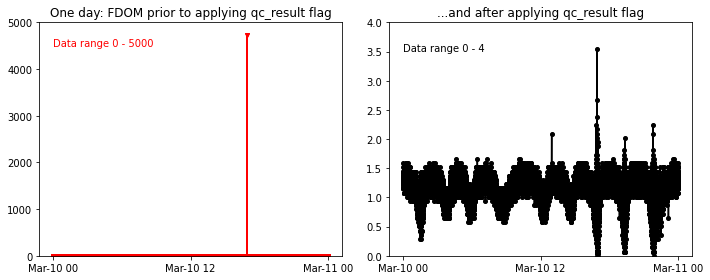

In [48]:
time_ticks = [dt64('2021-03-10'), dt64('2021-03-10 12'), dt64('2021-03-11')]

fig, axs = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

axs[0].plot(D1.time, D1.fdom,  ms=4., marker='v', color='r')
axs[1].plot(DC.time, DC.fdom,  ms=4., marker='o', color='k')

axs[0].set(ylim=(0.0, 5000.), title='One day: FDOM prior to applying qc_result flag')
axs[1].set(ylim=(0.0, 4.0),   title='...and after applying qc_result flag')

axs[0].xaxis.set_ticks(time_ticks)
axs[1].xaxis.set_ticks(time_ticks)
           
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H'))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b-%d %H'))

axs[0].text(dt64('2021-03-10'), 4500, 'Data range 0 - 5000', color='r')
axs[1].text(dt64('2021-03-10'), 3.5, 'Data range 0 - 4', color='k')


## Remark: Other qc flags

The other qc tests (higher order bits in the `_qc_results` flag) point to data 'of interest'. They are not a basis for filtering out
more data. 

## Human In The Loop annotations (HITL)


OOI provides annotation files through the Data Explorer. 
[Here is an example](https://dataexplorer.oceanobservatories.org/#metadata/104289/station/187/sensor/annotations).
Annotations can be downloaded as a table (CSV file) and
read into memory as shown below. 


The procedure given here reads the annotations file (staged with the data file) and scans the rows, 
specifically all of the annotation date ranges (one per row) to identify overlaps with the date range
of interest, in this case March 1 - April 1 2021. Here there are no overlaps so the 
end result is 'nothing to be done from HITL'.

In [59]:
annot = pd.read_csv('./HITLAnnotations/annotations_rca.csv')

dt64_MAR_1_2019, dt64_SEP_1_2019 = dt64('2019-03-01'), dt64('2019-09-01')
found_overlap = False
overlap_rows = []

for i in range(annot.shape[0]):
    if TimeOverlap(dt64_MAR_1_2019, dt64_SEP_1_2019, dt64(annot['beginDate'][i]), dt64(annot['endDate'][i])):
        found_overlap = True
        overlap_rows.append(i)

if found_overlap: 
    print('\n')
    print(len(overlap_rows), "time overlaps: annotations vs time range of interest. Rows:", overlap_rows)
    for i in range(len(overlap_rows)):
        print('      ', annot['beginDate'][overlap_rows[i]], '    to    ', annot['endDate'][overlap_rows[i]])
    print('\n')
else: 
    print('\n')
    print("No overlap between annotation record and time range of interest.")
    print('\n')




2 time overlaps: annotations vs time range of interest. Rows: [22, 29]
       2019-08-10T14:42:54     to     2019-08-24T08:45:45
       2019-06-24T19:03:08     to     2019-07-12T10:06:48




## Remark: Examining the 'annotations' data frame

The dimensions of the data frame can be printed using `print(annot.shape)`. The cells below illustrate
remarks from 'humans in the loop' over the course of operations for OOI arrays. 

In [60]:
# Examine the annotation data frame by referencing the first four rows, as:
annot[22:24]

,Unnamed: 0,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
22,22,2513,RS01SBPS,NaN,NaN,streamed,NaN,1565448174000,1566636345000,In August 2019 the platform experienced anothe...,False,m.vardaro@gmail.com,NaN,[],2019-08-10T14:42:54,2019-08-24T08:45:45
23,23,2514,RS01SBPS,SF01A,NaN,streamed,NaN,1569609712000,1596397261000,Instruments offline: Profiler taken offline on...,False,m.vardaro@gmail.com,not_operational,[],2019-09-27T18:41:52,2020-08-02T19:41:01


In [21]:
# Examine only a particular column of the annotation data frame
annot['beginDate'][0:4]

0    2018-03-21T00:13:00
1    2018-01-19T03:00:01
2    2020-11-02T00:11:32
3    2014-12-07T19:45:00
Name: beginDate, dtype: object

In [61]:
# Use the dataframe name on a line by itself to inspect the full annotation table, as in:
# annot
#
# Part 6 below uses data from June 14 2019, prior to annual maintenance. To further illustrate checking HITL annotations, here is an 
# annotation for later in 2019: June 24 -- July 12 by M.Vardaro.
annot['annotation'][29]

'Following the 2019 deployment, the platform experienced a several-day, major blow down event (350 m west, 48 m deep), most likely due to strong currents. The platform and profiler pod were inspected by the Jason ROV, but there was no visual indication of damage or other issue that could have caused the shift in location.'

## Remark: sample timing

The 'observation' coordinate is a simple counter. The 'time' coordinate/dimension consists of timestamps.
Time is the preferred dimension if multiple source data files come in to play as the ensemble is easily sorted.

In [62]:
# This code simplifies the datasets: It drops most of the 39 native Data Variables except those listed here.
DA = DA[['chlora']]
DB = DB[['backscatter', 'seawater_scattering_coefficient']]
DC = DC[['fdom']]

# Figure 3: Manual Intervention

We apply a median filter as an example of removing sensor noise.

In [63]:
DA

<xarray.Dataset>
Dimensions:  (time: 30445)
Coordinates:
    obs      (time) int32 3275978 3275984 3275994 ... 3347929 3347931 3347952
    lon      (time) float64 -125.4 -125.4 -125.4 -125.4 ... -125.4 -125.4 -125.4
    lat      (time) float64 44.53 44.53 44.53 44.53 ... 44.53 44.53 44.53 44.53
    depth    (time) float64 189.3 189.3 189.3 189.3 ... 189.3 189.3 189.3 189.3
  * time     (time) datetime64[ns] 2021-03-10T00:00:22.382923264 ... 2021-03-...
Data variables:
    chlora   (time) float64 0.0 0.0 0.0 0.0 0.0107 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes: (12/68)
    node:                               SF01A
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -125.3896636
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

In [64]:
DA_median_2S = DA.resample(time='2S').median()
DA_median_5S = DA.resample(time='5S').median()
DA_median_10S = DA.resample(time='10S').median()
DA_median_20S = DA.resample(time='20S').median()

DA_mean_20S = DA.resample(time='20S').mean()

Text(2021-03-10T08:24, 0.16, 'Mean filter (20 seconds): magenta')

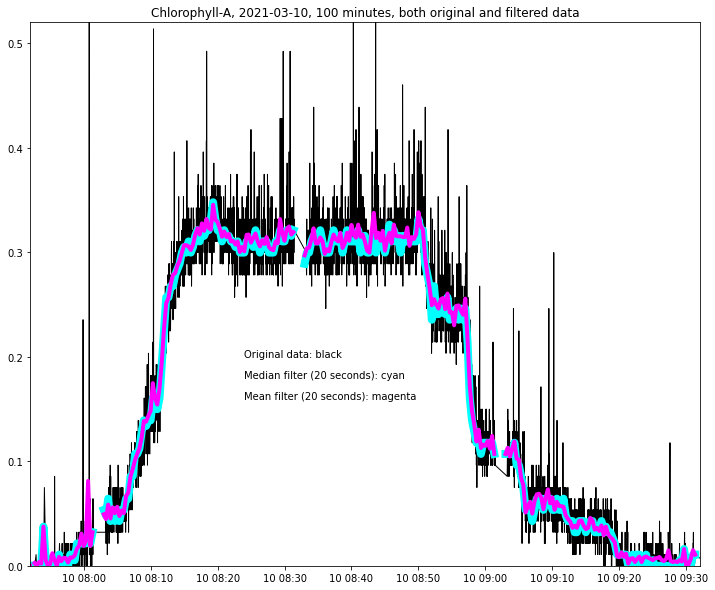

In [68]:
fig,ax=plt.subplots(figsize=(12,10))
ax.plot(DA.time, DA.chlora, color='k', lw=1)
ax.plot(DA_median_20S.time, DA_median_20S.chlora, color='cyan', lw=8)
ax.plot(DA_mean_20S.time, DA_mean_20S.chlora, color='magenta', lw=4)
ax.set(ylim=(-0.0, 0.52), xlim=(dt64('2021-03-10 07:52'), dt64('2021-03-10 09:32')), title='Chlorophyll-A, 2021-03-10, 100 minutes, both original and filtered data')
ax.text(dt64('2021-03-10 08:24'), 0.2, 'Original data: black', color='k')
ax.text(dt64('2021-03-10 08:24'), 0.18, 'Median filter (20 seconds): cyan', color='k')
ax.text(dt64('2021-03-10 08:24'), 0.16, 'Mean filter (20 seconds): magenta', color='k')


# Figure 4: Particulate backscatter

Calculated seawater scattering coefficient is available within the dataset. It is derived by OOI using 
from temperature and salinity. This is subtracted from total backscatter to arrive at particulate backscatter.

Here is the verbatim pseudo-code: 


```
Total optical backscatter ('bb', 700 nm): An OOI level 2 product
Particulate backscatter 'bb_p' is calculated as follows:

FOR i: over bb values of interest, e.g. a time series
    find matching / minimal distance temperature and salinity values for sample i
    calculate seawater backscatter 'bb_sw' as a function of this temperature and salinity per Zhang et al. (2009) 
    remove seawater backscatter from total backscatter to arrive at particulate backscatter
    bb_p(i) = bb(i) - bb_sw
```

The OOI-provided full-resolution FLORT data includes a pre-calculated seawater scattering coefficient. Hence, 
here is the practical implementation:

```
FOR LOOP { total backscatter time series }
    Establish bb and bb_sw(T, S) values
    particulate backscatter bb_p = bb - bb_sw
```

In [69]:
DB = DB.assign(particulate = lambda DB: DB.backscatter - DB.seawater_scattering_coefficient)
DB

<xarray.Dataset>
Dimensions:                          (time: 71998)
Coordinates:
    obs                              (time) int32 3275959 3275960 ... 3347956
    lon                              (time) float64 -125.4 -125.4 ... -125.4
    lat                              (time) float64 44.53 44.53 ... 44.53 44.53
    depth                            (time) float64 189.3 189.3 ... 189.3 189.3
  * time                             (time) datetime64[ns] 2021-03-10T00:00:0...
Data variables:
    backscatter                      (time) float64 0.0007715 ... 0.0009207
    seawater_scattering_coefficient  (time) float64 0.0006393 ... 0.0006392
    particulate                      (time) float64 0.0001322 ... 0.0002815
Attributes: (12/68)
    node:                               SF01A
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  streamed
    stream:                             flort_d_data_record
    ...                                 ...
    geospatial_lon_max:                 -125.3896636
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

[None]

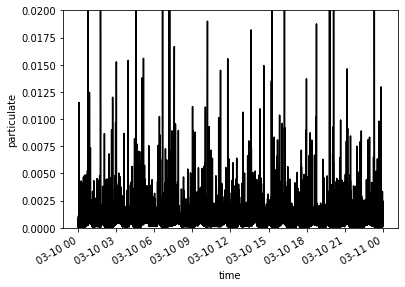

In [70]:
fig=DB.particulate.plot(ylim=(0.0, 0.02))[0]
fig.set(color='black')

[None]

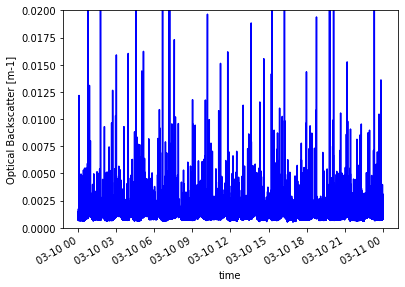

In [71]:
fig=DB.backscatter.plot(ylim=(0.0, 0.02))[0]
fig.set(color='blue')

[None]

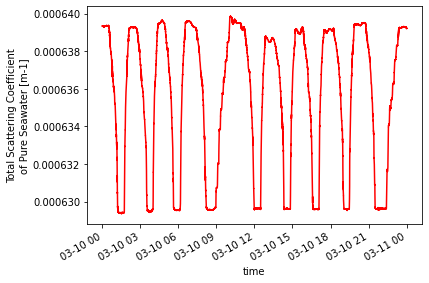

In [72]:
fig=DB.seawater_scattering_coefficient.plot()[0]
fig.set(color='red')

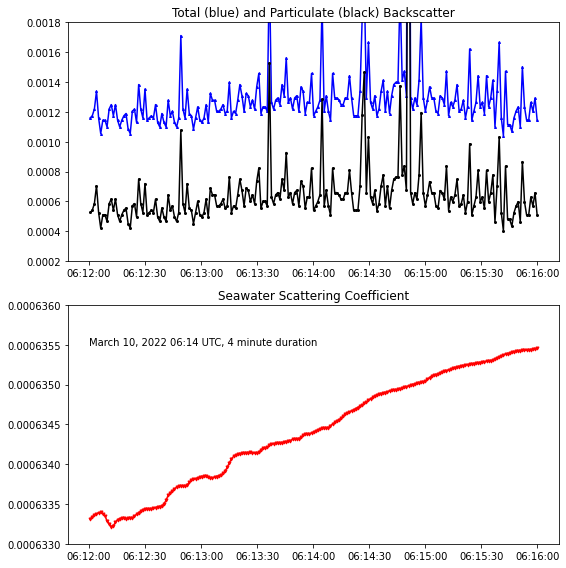

In [73]:
fig,axs=plt.subplots(2, figsize=(8,8), tight_layout=True)
dsmall = DB.sel(time=slice(dt64('2021-03-10 06:12'), dt64('2021-03-10 06:16')))

axs[0].plot(dsmall.time, dsmall.backscatter,                     ms=2., marker='^', linestyle='-', color='b')
axs[0].plot(dsmall.time, dsmall.particulate,                     ms=2., marker='o', linestyle='-', color='k')
axs[0].set(ylim=(0.0002,     0.0018  ), title='Total (blue) and Particulate (black) Backscatter')

axs[1].plot(dsmall.time, dsmall.seawater_scattering_coefficient, ms=3., marker='v', linestyle='-', color='r')
axs[1].set(ylim=(0.000633,  0.000636 ), title='Seawater Scattering Coefficient')
axs[1].text(dt64('2021-03-10 06:12'), .0006355, 'March 10, 2022 06:14 UTC, 4 minute duration')

fig.show()

#    ds_1day = ds.sel(time=slice(dt64(t0str), dt64(t1str)))   
#    fig, axs = plt.subplots(figsize=(12,4), tight_layout=True)   
#    axs.plot(ds_1day.time, ds_1day.z, marker='.', ms=9., color='k', mfc='r')   
#    axs.set(ylim = (-200., 0.), title=title)
#    axs.text(dt64('2021-02-28 23:15'), -184, 'AT')

# Figure 5: Profiler Chlor-A dark correction

# Figure 6: Discrete data comparative 

Source: [This notebook](https://github.com/robfatland/ocean/blob/2e4019439f9b0148457c20107b11514a0f0b916b/Notebooks/Ocean%2001%20B2%20Discrete%20Comparison.ipynb)


## Discrete data: Rosette casts during maintenance cruises

- Regional Cabled Array annual service cruises ("VISIONS" cruises) permit CTD casts near instrument sites
- In the case of this notebook we are interested in casts near the Oregon Slope Base (OSB) shallow profiler (SP)
- Niskin bottles are usually triggered on ascent ('upcast') at some sequence of depths
    - The water samples returned to the ship in this manner are 'discrete samples'
    - Casts typically take ~1 hour to complete
- Also attached to the rosette are sensors that operate continuously, typically ~1 measurement per second
    - Particularly a fluorometer which will be the basis for comparison to the shallow profiler fluorometer
    - The upcast fluorometer data is intentionally segmented
        - The segments correspond in time to the Niskin bottle triggers
        - The continuous fluorometer data is also available
- Discrete summary data files (niskin bottle timing) are CSV tables 
    - These are available from a dedicated Server called 'Alfresco'. 
    - They include rosette fluorometer data that appears discrete...
        - ...but in fact is excerpted from continuous data 
- Get data from the OOI 'Alfresco' server
    * [Alfresco browse site](https://alfresco.oceanobservatories.org/alfresco/faces/jsp/browse/browse.jsp)
    * Navigate: Cabled array > Cruise data > (year of choice) > Ship Data > Water Sampling
    * Example: (year of choice) = 2021 is folder **Cabled-12_TN393_2021-07-30**
        * TN refers to the ship: Thompson. Atlantis = AT; Revelle = RR; Sikuliaq = SKQ (2016 cruise)
        * 393 refers to the cruise number
            * Cabled-12 indicates the OOI Regional Cabled Array; where 12 is simply an index number (by year)
            * For the OOI cabled array the annual cruise uses Newport OR as the base of operations
            * The cruise consists of a series of sorties or 'legs', each typically 5-10 days
            * The provided date 2021-07-30 indicates the year and approximate date of the cruise start
    * In the Water Sampling folder there are two files of interest
        * **Cabled-12_TN393_Discrete_Summary-README.pdf** is a guide to deciphering the data, particularly ephemeris flags
        * **Cabled-12_TN393_Discrete_Summary.csv** is a tabular data file 
            * This file is the **Discrete Summary** of interest
            * It summarizes cast sample data and synchronous continuous sensor data; see below
- Additional notes
    - Samples are most commonly taken by a [rosette](https://www.whoi.edu/what-we-do/explore/instruments/instruments-sensors-samplers/rosette-sampler/)
    - A Remotely Operated Vehicle (ROV) can also be used as a Niskin bottle framework
    - Other types of continuous sensor data from casts include seawater conductivity, temperature, and depth
    - Notes on abbreviations found in the OOI system and data filenames    
        - Cast reference site: **`SP`** is Shallow Profiler station. Cast location is stated relative; but the cast might go much deeper than 200 meters.
        - Cast sequence: **`CTD-005`** is a CTD cast with index (skips are common)
        - Cast location: **`500m SW`** indicates an offset southwest (SW) from the station position
    - The repo folder **`DiscreteSummaries`** contains:
        - Tabular data (**`.csv`**) for 2015 - 2021
        - README metadata (**`.pdf`**) for 2015 - 2021
- VISIONS cruise casts for Oregon Slope Base Shallow Profiler
    - These cast dates are listed in relation to end-of-deployment 'SP stop' times.
    - Comparison of "start of deployment" SP data with cast data is not shown here.
    - 2014--2017 Casts: None
    - 2018
        - OSB SP, CTD-002, 2018-06-26T20:23Z, 500m W
            - SP deployed Aug 4, 2017 through Jun 24, 2018 02:00Z
                - The cast above on June 26 is 2 days 18 hrs after SP stop
        - OSB SP, CTD-006, 2018-07-10T20:46Z, 250m W
        - OSB SP, CTD-008, 2018-07-10T22:44Z, 500m W
            - These two casts apparently ran in succession
            - SP deployed "briefly" Jun 24, 2018 through Jul 9, 2018 12:00Z
                - The two casts above on July 10 are 34 hours after this brief SP deployment
    - 2019
        - OSB SP, CTD-006, 2019-06-14T11:24Z,  250m W
            - SP deployed Jul 9, 2018 through Jun 14, 2019 05:26Z
                - The cast above on June 14 is 6 hours after SP stop
        - OSB SP, CTD-010, 2019-06-27T19:38Z,  250m W
    - 2020
        - OSB SP, CTD-001, 2020-08-03T15:18Z,    0m
            - SP deployed Jun 14, 2019 through Aug 2, 2020 19:41Z
                - The cast above on Aug 3 is 19 hours after SP stop
        - OSB SP, CTD-006, 2020-08-11T04:28Z, 1300m NE
        - OSB SP, CTD-007, 2020-08-11T05:48Z, 1300m NE
    - 2021
        - OSB SP, CTD-005, 2021-08-06T01:44Z, 500m SW
            - Aug 3, 2020 through Aug 4, 2021 20:20Z
                - The cast above on Aug 6 is 30 hours after SP stop
                
Based on this time sequence we proceed to compare 2019 last clean SP ascent with cast CTD-006 on June 14.

In [74]:
# Read the Discrete Summary (CSV) table for Regional Cabled Array 2019
DiscSumm = pd.read_csv('./DiscreteSummaries/RCA2019_AT_DiscSumm.csv')
# DiscSumm.shape gives 145 rows, 80 columns

# The 80 columns have header keys in the first row, printed below
#   Only the CTD-006 cast rows are used here. There are 17 with depths varying from 220m to 11m.
#   There is no direct correspondence to the FLORT sensor names.

DS6 = DiscSumm[DiscSumm["Cast"] == "CTD-006"]
DS6.keys()

Index(['Cruise', 'Station', 'Target Asset', 'Start Latitude [degrees]',
       'Start Longitude [degrees]', 'Start Time [UTC]', 'Cast', 'Cast Flag',
       'Bottom Depth at Start Position [m]', 'CTD File', 'CTD File Flag',
       'Niskin/Bottle Position', 'Niskin Flag',
       'CTD Bottle Closure Time [UTC]', 'CTD Pressure [db]',
       'CTD Pressure Flag', 'CTD Depth [m]', 'CTD Latitude [deg]',
       'CTD Longitude [deg]', 'CTD Temperature 1 [deg C]',
       'CTD Temperature 1 Flag', 'CTD Temperature 2 [deg C]',
       'CTD Temperature 2 Flag', 'CTD Conductivity 1 [S/m]',
       'CTD Conductivity 1 Flag', 'CTD Conductivity 2 [S/m]',
       'CTD Conductivity 2 Flag', 'CTD Salinity 1 [psu]',
       'CTD Salinity 2 [psu]', 'CTD Oxygen [mL/L]', 'CTD Oxygen Flag',
       'CTD Oxygen Saturation [mL/L]', 'CTD Fluorescence [mg/m^3]',
       'CTD Fluorescence Flag', 'CTD Beam Attenuation [1/m]',
       'CTD Beam Transmission [%]', 'CTD Transmissometer Flag', 'CTD pH',
       'CTD pH Flag', 'D

In [75]:
# This code excerpts several columns of interest from the Discrete Summary table for cast 6

c6_depth           = DS6["CTD Depth [m]"]                             # runs 200 ... 11 meters
c6_fluor           = DS6["CTD Fluorescence [mg/m^3]"]                 # 
c6_fluor_flag      = DS6["CTD Fluorescence Flag"]                     # for all: flags 2 and 6 set, flag 7 for good discrete samples
c6_beam_atten      = DS6["CTD Beam Attenuation [1/m]"]
c6_beam_trans      = DS6["CTD Beam Transmission [%]"]
c6_trans_flag      = DS6["CTD Transmissometer Flag"]
c6_chlor           = DS6["Discrete Chlorophyll [ug/L]"]
c6_phaeo           = DS6["Discrete Phaeopigment [ug/L]"]
c6_disc_fluor_flag = DS6["Discrete Fluorescence Flag"]
c6_disc_fluor_repl = DS6["Discrete Fluorescence Replicate Flag"]

In [76]:
# There appear to be 17 discrete samples, triggered at the following depths (meters)
print(c6_depth)

18    219.896
19    219.975
20    200.163
21    179.892
22    161.044
23    141.270
24    121.243
25    100.224
26     81.152
27     60.165
28     60.238
29     40.457
30     40.365
31     20.680
32     20.627
33     11.181
34     11.181
Name: CTD Depth [m], dtype: float64


In [77]:
# Summary of valid data for five data types
#
# Contain data at all 17 keys/depths: c6_fluor, c6_beam_atten, c6_beam_trans
# Contain data at good_discrete_keys[] only: c6_phaeo ~0.1, c6_chlor ~.5, 
# Flag indicates data are ok at good_discrete_keys[]: c6_disc_fluor_flag, c6_disc_fluor_repl
#
# How this breaks down:
# 'CTD' data (continuous sensors) are usable for the entire upcast
# 'Discrete' (water sample) data are usable for only 5 of the 17 discrete rows for CTD 006.
all_keys = list(range(18, 35))
good_discrete_keys = [25, 27, 28, 31, 32]
for i in good_discrete_keys: print(i, c6_chlor[i], c6_depth[i])
print("\nexample of no available data: ", c6_chlor[18])

25 0.0652 100.224
27 0.8852 60.165
28 0.9125 60.238
31 0.2398 20.68
32 0.2433 20.627

example of no available data:  -9999999.0


In [78]:
# This code isolates depths and sensors for overlay/comparison on the Shallow Profiler charts below
disc_depth, disc_phaeo, disc_chlor, ctd_depth, ctd_atten = [], [], [], [], []
for i in good_discrete_keys:
    disc_depth.append(c6_depth[i])
    disc_phaeo.append(c6_phaeo[i])
    disc_chlor.append(c6_chlor[i])
for i in all_keys:
    ctd_depth.append(c6_depth[i])
    ctd_atten.append(c6_beam_atten[i])

In [79]:
# Example code for 2018 (not used further here)
#
# D2018 = xr.open_dataset('../data/rca/fluor/osb/2018/flort_fullres.nc')
# D2018 = D2018.swap_dims({'obs':'time'}) 
# print('Number of data values: ', len(D2018.time)) gives 1029224 samples
# D2018 = D2018.rename( {'fluorometric_cdom':          'fdom',
#                        'fluorometric_chlorophyll_a': 'chlora',
#                        'optical_backscatter':        'backscatter'})
# print(D2018.time[0], D2018.time[-1]) provides: 2018-06-24T16:50 through 2018-07-09T00:13, 15 days
# D2018

In [80]:
# This code reads and formats the Shallow Profiler dataset for June 2019

D2019 = xr.open_dataset('../data/rca/fluor/osb/2019/flort_fullres.nc')
D2019 = D2019.swap_dims({'obs':'time'})
print('Number of source data values: ', len(D2019.time))
D2019 = D2019.dropna('time')
print('D number of data values after dropping NaNs: ', len(D2019.time))
D2019 = D2019.rename( {'fluorometric_cdom':          'fdom',
                       'fluorometric_chlorophyll_a': 'chlora',
                       'optical_backscatter':        'backscatter'})
# print(D2019.time[0], D2019.time[-1]) provides: 2019-04-10T12:00 through 2019-06-14T05:12, about 64 days 
d2019 = D2019.sel(time=slice(dt64('2019-06-14 02:40'), dt64('2019-06-14 04:40')))
print('Data value count for final profile of deployment: ', len(d2019.time))
d2019A = d2019.where(d2019.fluorometric_chlorophyll_a_qc_results % 2, drop=True)
d2019B = d2019.where(d2019.optical_backscatter_qc_results % 2,        drop=True)
d2019C = d2019.where(d2019.fluorometric_cdom_qc_results % 2,          drop=True)
# Drop all Data Variables except those of interest ('chlora' and so on)
d2019A = d2019A[['chlora']]
d2019B = d2019B[['backscatter', 'seawater_scattering_coefficient']]
d2019C = d2019C[['fdom']]
print('Data sizes for source data and post-qc-discards for chlora, backscatter and fdom:', 
      len(d2019.time), '->', len(d2019A.time), ';', len(d2019B.time), ';', len(d2019C.time))

Number of source data values:  4609190
D number of data values after dropping NaNs:  4609189
Data value count for final profile of deployment:  6000
Data sizes for source data and post-qc-discards for chlora, backscatter and fdom: 6000 -> 4594 ; 6000 ; 6000


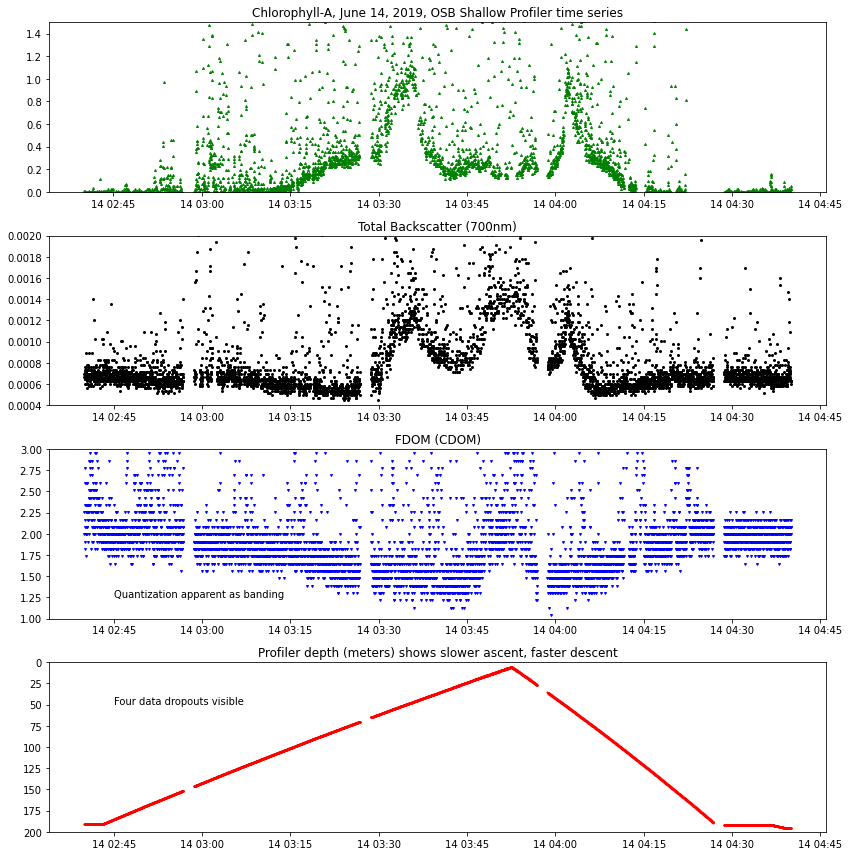

In [81]:
# Time series charts for June 14, 2019: 3 hours spanning the final profile of the deployment
#   prior to a maintenance update.

fig,axs=plt.subplots(4, figsize=(12,12), tight_layout=True)

axs[0].plot(d2019A.time, d2019A.chlora,       ms=2., marker='^', linestyle='None', color='g')
axs[1].plot(d2019B.time, d2019B.backscatter,  ms=2., marker='o', linestyle='None', color='k')
axs[2].plot(d2019C.time, d2019C.fdom,         ms=2., marker='v', linestyle='None', color='b')
axs[3].plot(d2019C.time, d2019C.depth,        ms=2., marker='.', linestyle='None', color='r')


axs[0].set(ylim=(0.0   , 1.5  ), title='Chlorophyll-A, June 14, 2019, OSB Shallow Profiler time series')
axs[1].set(ylim=(0.0004,  .002), title='Total Backscatter (700nm)')
axs[2].set(ylim=(1.0   , 3.0  ), title='FDOM (CDOM)')
axs[3].set(ylim=( 200  , 0.0  ), title='Profiler depth (meters) shows slower ascent, faster descent')

axs[2].text(dt64('2019-06-14 02:45'), 1.25, 'Quantization apparent as banding')
axs[3].text(dt64('2019-06-14 02:45'), 50., 'Four data dropouts visible')

fig.show()

In [94]:
# Bin results by depth for comparison with discrete (cast) data

depth_bounds = [0., 15., 30., 50., 70., 90., 110., 130., 150., 170., 190., 250.]    
depth_labels = [10., 20., 40, 60., 80., 100., 120., 140., 160., 180., 200.]

# depth_bounds = np.arange(0., 217., 6.)  
# depth_labels = np.arange(3., 215., 6.)

chlora_binned      = d2019A.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).mean()
backscatter_binned = d2019B.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).mean()
fdom_binned        = d2019C.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).mean()

chlora_std      = d2019A.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).std()
backscatter_std = d2019B.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).std()
fdom_std        = d2019C.sortby('depth').groupby_bins('depth', depth_bounds, labels=depth_labels).std()

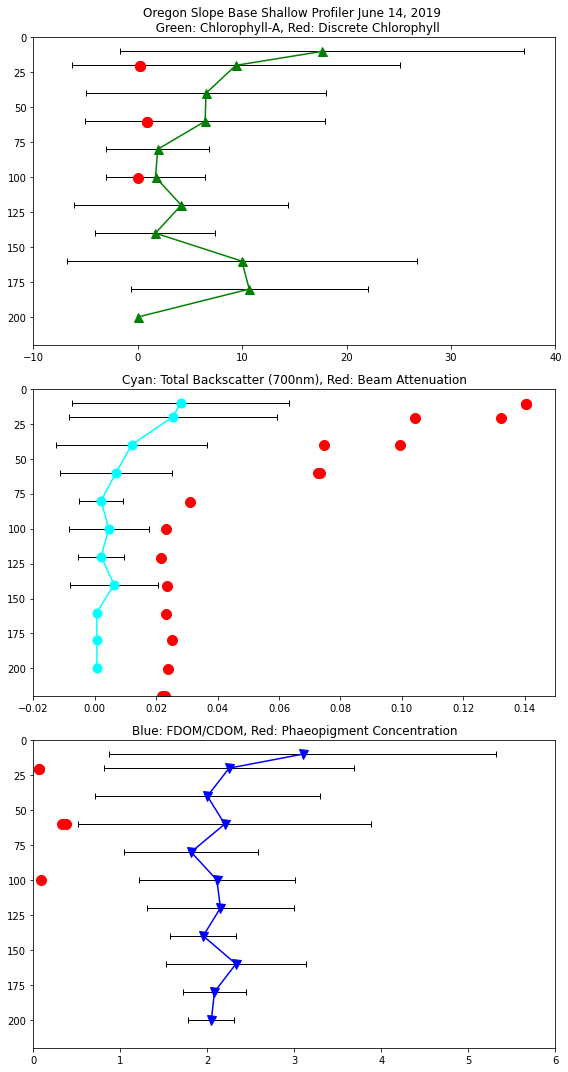

In [95]:
fig,axs=plt.subplots(3, figsize=(8,15), tight_layout=True)

axs[0].errorbar(chlora_binned.chlora,           chlora_binned.depth_bins,  
                xerr=chlora_std.chlora, ecolor='k', elinewidth=1, capsize=3,
                ms=9., marker='^', linestyle='-', color='g')
axs[1].errorbar(backscatter_binned.backscatter, backscatter_binned.depth_bins, 
                xerr=backscatter_std.backscatter, ecolor='k', elinewidth=1, capsize=3,
                ms=9., marker='o', linestyle='-', color='cyan')
axs[2].errorbar(fdom_binned.fdom,               fdom_binned.depth_bins,        
                xerr=fdom_std.fdom, ecolor='k', elinewidth=1, capsize=3,
                ms=9., marker='v', linestyle='-', color='b')

axs[0].set(ylim=(220., 0.), xlim=(-10.0   , 40  ), title='Oregon Slope Base Shallow Profiler June 14, 2019 \n  Green: Chlorophyll-A, Red: Discrete Chlorophyll')
axs[1].set(ylim=(220., 0.), xlim=(-.02,  0.15), title='Cyan: Total Backscatter (700nm), Red: Beam Attenuation')
axs[2].set(ylim=(220., 0.), xlim=(0.   , 6  ), title='Blue: FDOM/CDOM, Red: Phaeopigment Concentration')

axs[0].plot(disc_chlor, disc_depth, marker='o', ms=10, color='r', linestyle='None')
axs[1].plot(ctd_atten,  ctd_depth,  marker='o', ms=10, color='r', linestyle='None')
axs[2].plot(disc_phaeo, disc_depth, marker='o', ms=10, color='r', linestyle='None')

fig.show()

M.Vardaro notes that not all bottles are analyzed for fluorescence. He suggested the matching scheme used in the above charts:

```
FLORT-CDOM [ppb] = Discrete Phaeopigment [ug/L]
FLORT-ChlA [ug/L] = Discrete Chlorophyll [ug/L]
FLORT-Backscatter (1/m) = Beam Attenuation (1/m)
```